In [1]:
import sys
if 'google.colab' in sys.modules:
    !pip --quiet install atmos-cloud-sim-uj-utils
    from atmos_cloud_sim_uj_utils import pip_install_on_colab
    pip_install_on_colab('PySDM-examples')

In [2]:
import string
import os

import numpy as np
from scipy.io import netcdf_file
from scipy.ndimage import uniform_filter1d
import matplotlib
from matplotlib import pyplot

from PySDM.exporters import NetCDFExporter, VTKExporter
import PySDM.products as PySDM_products
from PySDM.physics import si
from PySDM import Formulae
from PySDM.initialisation.spectra import Lognormal

from PySDM_examples.Arabas_et_al_2015 import Settings, SpinUp
from PySDM_examples.Szumowski_et_al_1998 import Simulation, Storage
from PySDM_examples.UIUC_2021.commons import FREEZING_CONSTANTS, LOGNORMAL_MODE_SURF_A, LOGNORMAL_SGM_G
from PySDM_examples.utils import ProgBarController

from atmos_cloud_sim_uj_utils import show_plot

/home/slayoo/devel/PySDM/PySDM/backends/__init__.py:32: UserWarning: CUDA library found but cuInit() failed (error code: 999; message: unknown error)
  warnings.warn(


In [3]:
formulae = Formulae(
    freezing_temperature_spectrum='Niemand_et_al_2012',
    heterogeneous_ice_nucleation_rate='ABIFM',
    constants=FREEZING_CONSTANTS["dust"]
)

lognormal_mode_A = LOGNORMAL_MODE_SURF_A
lognormal_sgm_g = LOGNORMAL_SGM_G
aero_mult = 3
inp_frac = .0015 / aero_mult

# TODO #599: this is not specific concentration!!!
spec_conc_unit = '1/cc'
spec_conc_ice_unit = '1/l'
cool_rate_unit = 'K/min'
wall_time_unit = 'ms'

In [4]:
runs = (
    {'settings': {'rhod_w_max': 3. * si.m/si.s*si.kg/si.m**3, 'freezing_singular': False}},
    {'settings': {'rhod_w_max': 3. * si.m/si.s*si.kg/si.m**3, 'freezing_singular': True}},
    {'settings': {'rhod_w_max': 1. * si.m/si.s*si.kg/si.m**3, 'freezing_singular': False}},
    {'settings': {'rhod_w_max': 1. * si.m/si.s*si.kg/si.m**3, 'freezing_singular': True}},
    {'settings': {'rhod_w_max': 1/3. * si.m/si.s*si.kg/si.m**3, 'freezing_singular': False}},
    {'settings': {'rhod_w_max': 1/3. * si.m/si.s*si.kg/si.m**3, 'freezing_singular': True}},
)

In [5]:
products = (
    PySDM_products.PeakSupersaturation(name='S_max', unit='%'),
    PySDM_products.DynamicWallTime('Freezing', name='Freezing_wall_time', unit=wall_time_unit),
    # TODO #599: add SVP version of the products
    PySDM_products.ParticleConcentration(radius_range=(-np.inf, -1*si.um), name='n_i', unit=spec_conc_ice_unit),
    PySDM_products.ParticleConcentration(radius_range=(0, 1*si.um), name='n_a', unit=spec_conc_unit),
    PySDM_products.ParticleConcentration(radius_range=(1*si.um, np.inf), name='n_c', unit=spec_conc_unit),
    PySDM_products.EffectiveRadius(name='r_eff', unit='um'),
    PySDM_products.CoolingRate(unit=cool_rate_unit),
    PySDM_products.AmbientRelativeHumidity(name='RH_env', var='RH'),
    PySDM_products.AmbientTemperature(name='T_env', var='T'),
    PySDM_products.SuperDropletCountPerGridbox(),
    PySDM_products.FlowVelocityComponent(component=0, name='ux'),
    PySDM_products.FlowVelocityComponent(component=1, name='uz'),
    PySDM_products.MaxCourantNumber(),
    PySDM_products.IceNucleiConcentration(name='n_inp', unit=spec_conc_ice_unit),
    PySDM_products.FrozenParticleConcentration(name='n_frozen_aerosols', unit=spec_conc_ice_unit,
                                               count_activated=False, count_unactivated=True),
    PySDM_products.FrozenParticleConcentration(name='n_frozen_droplets', unit=spec_conc_ice_unit,
                                               count_activated=True, count_unactivated=False)
)
to_base_unit_multipliers = {product.name: product.unit_magnitude_in_base_units for product in products}

In [6]:
for i, run in enumerate(runs):
    folder = f"output/rhod_w_max={run['settings']['rhod_w_max']}_singular={run['settings']['freezing_singular']}"
    os.makedirs(folder, exist_ok=True)
    
    run['ncfile'] = f'{folder}/out.nc'
    
    settings = Settings(formulae)
    settings.dt = 2.5 * si.s
    settings.output_interval = settings.dt * 12
    settings.simulation_time = 3000 * si.second if 'CI' not in os.environ else settings.output_interval
    settings.spin_up_time = 600 * si.second
    settings.size = (1500, 500)
    settings.n_sd_per_gridbox = 64
    settings.grid = (60, 20)
    settings.th_std0 -= 33.3 * si.kelvins
    settings.qv0 -= 6.66 * si.grams / si.kilogram
    
    settings.processes['coalescence'] = False
    settings.processes['freezing'] = True
    settings.freezing_inp_spec = Lognormal(
        norm_factor=1,
        m_mode=lognormal_mode_A,
        s_geom=lognormal_sgm_g
    )
    settings.freezing_inp_frac = inp_frac
    
    settings.mode_1.norm_factor *= aero_mult
    settings.mode_2.norm_factor *= aero_mult
    settings.spectrum_per_mass_of_dry_air.norm_factor *= aero_mult
    
    for key, value in run['settings'].items():        
        assert hasattr(settings, key)
        setattr(settings, key, value)

    storage = Storage()
    simulation = Simulation(settings, storage, SpinUp=SpinUp)
    simulation.reinit(products)

    vtk_exporter = VTKExporter(path=folder)    
    simulation.run(ProgBarController(f"run {i+1}/{len(runs)}"), vtk_exporter=vtk_exporter)
    vtk_exporter.write_pvd()

    ncdf_exporter = NetCDFExporter(storage, settings, simulation, run['ncfile'])
    ncdf_exporter.run(ProgBarController('netCDF'))

FloatProgress(value=0.0, description='run 1/6', max=1.0)

FloatProgress(value=0.0, description='netCDF', max=1.0)

FloatProgress(value=0.0, description='run 2/6', max=1.0)

FloatProgress(value=0.0, description='netCDF', max=1.0)

FloatProgress(value=0.0, description='run 3/6', max=1.0)

FloatProgress(value=0.0, description='netCDF', max=1.0)

FloatProgress(value=0.0, description='run 4/6', max=1.0)

FloatProgress(value=0.0, description='netCDF', max=1.0)

FloatProgress(value=0.0, description='run 5/6', max=1.0)

FloatProgress(value=0.0, description='netCDF', max=1.0)

FloatProgress(value=0.0, description='run 6/6', max=1.0)

FloatProgress(value=0.0, description='netCDF', max=1.0)

In [7]:
def label(settings):
    lbl = str({k.replace('condensation_', ''):
               f"{v:.1e}" if isinstance(v, float) else
               str(v).zfill(2) if isinstance(v, int) else
               v for k, v in settings.items()})
    return lbl\
        .replace('{', '')\
        .replace('}', '')\
        .replace("'", '')\
        .replace('rhod_w_max:', '$w_{max}\\approx$')\
        .replace('.0e+00', r' $\,\,\,\,$ m/s')\
        .replace('3.3e-01', '1/3 m/s')\
        .replace('freezing_singular: True', r'singular$\,\,\,$')\
        .replace('freezing_singular: False', 'time-dep')

(CPU: 1.60ms)
(CPU: 0.88ms)
(CPU: 2.05ms)
(CPU: 0.65ms)
(CPU: 1.40ms)
(CPU: 0.69ms)
(CPU: 1.60ms)
(CPU: 0.88ms)
(CPU: 2.05ms)
(CPU: 0.65ms)
(CPU: 1.40ms)
(CPU: 0.69ms)
(CPU: 1.60ms)
0.0 359.14856
(CPU: 0.88ms)
0.0 340.129
(CPU: 2.05ms)
0.0 335.05975
(CPU: 0.65ms)
0.0 313.056
(CPU: 1.40ms)
0.0 302.02237
(CPU: 0.69ms)
0.0 330.21127
(CPU: 1.60ms)
(CPU: 0.88ms)
(CPU: 2.05ms)
(CPU: 0.65ms)
(CPU: 1.40ms)
(CPU: 0.69ms)
(CPU: 1.60ms)
(CPU: 0.88ms)
(CPU: 2.05ms)
(CPU: 0.65ms)
(CPU: 1.40ms)
(CPU: 0.69ms)


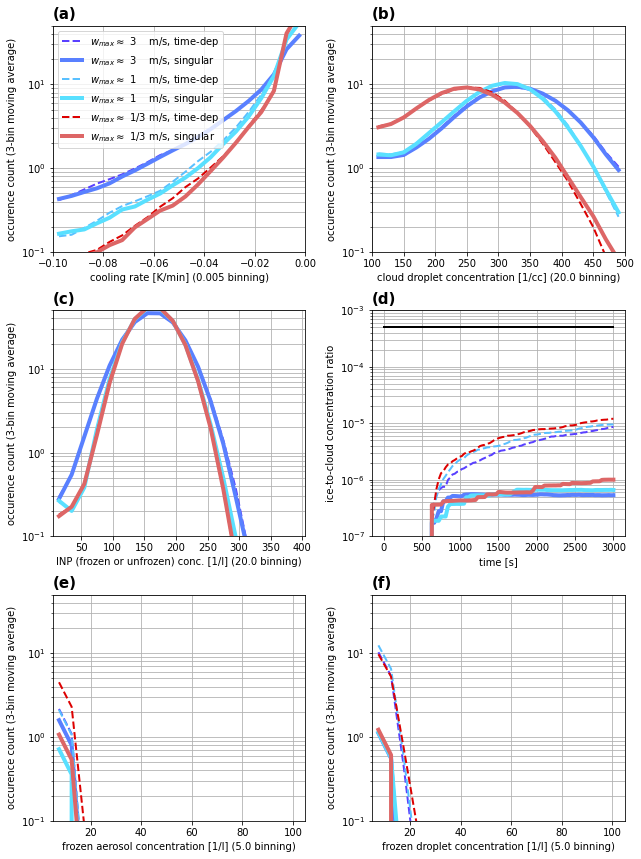

HTML(value="<a href='./figures.pdf' target='_blank'>./figures.pdf</a><br>")

In [10]:
matplotlib.rcParams["figure.figsize"] = (9, 12)
colors = (
    '#5940ff', '#5980ff', '#59c0ff', '#59e0ff', 
    '#dd0000', '#dd6666', '#dd9999', '#ddcccc', 
    '#777777', '#aaaaaa'
)
n_last_steps = 500
bins = 20
bin_range = {
    'cooling rate': (-.1, 0),
#     'S_max': (.02, 1.01),
#     'r_eff': (1.5, 6.5),
    'n_c': (100, 500),
    'n_inp': (5, 405),
    'n_i': None,
    'n_frozen_aerosols': (5, 105),
    'n_frozen_droplets': (5, 105)
#    'n_a': (0, 128*(aero_mult)+100),
#     'T_env': (220, 275),
#     'RH_env': (0, 1)
}
window = 3

rows = 3
columns = 2

fig, axs = pyplot.subplots(rows, columns, sharey=False, tight_layout=True)
for plot_i, var in enumerate(bin_range.keys()):
    if len(axs.shape) == 2:
        ax = axs[plot_i//columns][plot_i%columns]
    else:
        ax = axs[plot_i]
    for i, run in enumerate(runs):
        nc = netcdf_file(run['ncfile'], mode='r', mmap=False)
        n_spinup = nc.n_spin_up // nc.steps_per_output_interval  # TODO #599: unused!
        data = nc.variables[var]
        timesteps = slice(-(n_last_steps+1), None)

        style = {
            'color': colors[i], 
            'lw': 4 if run['settings']['freezing_singular'] else 2,
            'ls': '--' if not run['settings']['freezing_singular'] else '-'
        }
        
        if var != 'n_i':
            wall_time = np.nanmean(nc.variables['Freezing_wall_time'][timesteps] / nc.steps_per_output_interval)
            wall_time = np.nan if not np.isfinite(wall_time) else int(100 * wall_time) / 100
            print(f"(CPU: {wall_time:.2f}{wall_time_unit})")      

            y, x, _ = ax.hist(data[timesteps, :, :].flatten(), 
                                  bins=bins, range=bin_range[var], histtype='step', 
                                  color=colors[i], lw=0)
            y /= n_last_steps
            filt_x = x[:-1] if window % 2 == 0 else (x[1:] + x[:-1])/2
            ax.plot(filt_x, uniform_filter1d(y, size=window), **style,
                            label=f"{label(run['settings'])}"
                       )
            ax.set_yscale('log')
            #ax.set_ylim(.01 * np.prod(nc.grid), .1 * np.prod(nc.grid))
            ax.set_ylim(.1, 50)
            ax.set_ylabel('occurence count ' + f'({window}-bin moving average)')
            binwidth = (bin_range[var][1]-bin_range[var][0])/bins
            ax.set_xlim(bin_range[var])
            if var == 'S_max':
                ax.set_xlabel(f'peak supersaturation [%] ({binwidth}% binning)')
            elif var == 'r_eff':
                ax.set_xlabel(f'cloud droplet effective radius [μm] ({binwidth} binning)')
            elif var == 'n_i':
                ax.set_xlabel(f'ice concentration [{spec_conc_ice_unit}] ({binwidth} binning)')
            elif var == 'n_inp':
                print(np.amin(data[:]), np.amax(data[:]))
                ax.set_xlabel(f'INP (frozen or unfrozen) conc. [{spec_conc_ice_unit}] ({binwidth} binning)')
            elif var == 'n_a':
                ax.set_xlabel(f'aerosol  concentration [{spec_conc_unit}] ({binwidth} binning)')
            elif var == 'n_frozen_aerosols':
                ax.set_xlabel(f'frozen aerosol concentration [{spec_conc_ice_unit}] ({binwidth} binning)')
            elif var == 'n_frozen_droplets':
                ax.set_xlabel(f'frozen droplet concentration [{spec_conc_ice_unit}] ({binwidth} binning)')
            elif var == 'n_c':
                ax.set_xlabel(f'cloud droplet concentration [{spec_conc_unit}] ({binwidth} binning)')
            elif var == 'T_env':
                ax.set_xlabel(f'ambient temperature [K] ({binwidth} binning)')
            elif var == 'RH_env':
                ax.set_xlabel(f'ambient RH [1] ({binwidth} binning)')
            elif var == 'cooling rate':
                ax.set_xlabel(f'cooling rate [{cool_rate_unit}] ({binwidth} binning)')
            else:
                assert False
        else:
            n_ice = np.mean(np.mean(data[timesteps,:,:], axis=1), axis=1) 
            n_ice *= to_base_unit_multipliers['n_i']

            n_cld = np.mean(np.mean(nc.variables['n_c'][timesteps,:,:], axis=1), axis=1) 
            n_cld *= to_base_unit_multipliers['n_c']
            
            ax.plot(
                nc.variables['T'][timesteps],
                n_ice / n_cld,
                **style
            )
            ax.plot(nc.variables['T'][timesteps][[0,-1]], [inp_frac, inp_frac], color='black')
            ax.set_yscale('log')
            ax.set_ylim(1e-7, 1e-3)
            ax.set_ylabel('ice-to-cloud concentration ratio')
            ax.set_xlabel('time [s]')            
            
    ax.grid(which='minor')
    ax.grid(which='major')
    if plot_i == 0:
        ax.legend()
    ax.text(0, 1.03,
            '('+string.ascii_lowercase[plot_i]+')',
            transform=ax.transAxes, size=15, weight='bold')
show_plot("figures.pdf")